In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.spatial.distance as dist
from scipy.io import wavfile
import IPython.display as ipyd
import librosa
import librosa.display
import soundfile as sf

def remove_trailing_silence(audio_file):
    audio, sr = librosa.load(audio_file, sr= 32000, mono=True)
    clip = librosa.effects.trim(audio, top_db= 20)
    sf.write('filtered.wav', clip[0], 32000)
    

def getMel(f_s, x):
    n_fft = int(0.025*f_s)      # 25 ms
    hop_length = int(0.01*f_s)  # 10 ms
    mel_spec_x = librosa.feature.melspectrogram(
        x/1.0, sr=f_s, n_mels=40,
        n_fft=n_fft, hop_length=hop_length
        )
    log_mel_spec_x = np.log(mel_spec_x)
    x_seq = log_mel_spec_x.T
    return x_seq

def dtw(dist_mat):
# Credit to Herman Kamper for his dtw algorithm example

    N, M = dist_mat.shape

    cost_mat = np.zeros((N + 1, M + 1))
    for i in range(1, N + 1):
        cost_mat[i, 0] = np.inf
    for i in range(1, M + 1):
        cost_mat[0, i] = np.inf

    traceback_mat = np.zeros((N, M))
    for i in range(N):
        for j in range(M):
            penalty = [
                cost_mat[i, j],  
                cost_mat[i, j + 1],  
                cost_mat[i + 1, j]]  
            i_penalty = np.argmin(penalty)
            cost_mat[i + 1, j + 1] = dist_mat[i, j] + penalty[i_penalty]
            traceback_mat[i, j] = i_penalty

    i = N - 1
    j = M - 1
    path = [(i, j)]
    while i > 0 or j > 0:
        tb_type = traceback_mat[i, j]
        if tb_type == 0:
            i = i - 1
            j = j - 1
        elif tb_type == 1:
            i = i - 1
        elif tb_type == 2:
            j = j - 1
        path.append((i, j))

    cost_mat = cost_mat[1:, 1:]
    return path[::-1], cost_mat

def getCost(x_seq, y_seq):
    M = y_seq.shape[0]
    N = x_seq.shape[0]
    dist_mat = dist.cdist(x_seq, y_seq, "cosine")
    path, cost_mat = dtw(dist_mat)
    cost_mat_normalized = cost_mat / (M + N)

    return path, cost_mat, cost_mat_normalized

def splitSearch(q, search, step_size):
    q_length = q.shape[0]
    search_length = search.shape[0]
    step_num = 0
    searches = []
    while (step_num*step_size+q_length < search_length):
        searches.append(search[step_num*step_size:step_num*step_size+q_length])
        step_num+=1
    return searches

def getCosts(q, searches):
    costs=[]
    for i in searches:
        path, cost_mat, cost_mat_normalized = getCost(q, i)
        costs.append(cost_mat_normalized[-1, -1].tolist())
    return costs

def getScaled(num_costs, num):
    max_cost_len=max(num_costs)
    if num_costs[num]-1 > 0:
        div=max_cost_len/float(num_costs[num]-1)
    else:
        div=max_cost_len
    print(div)
    x=[0]
    for i in range(1,num_costs[num]):
        x.append(i*div)
    return x

In [3]:
filtered = 'filtered.wav'
x_fn = "eat1.wav"
remove_trailing_silence(x_fn)
f_s, x = wavfile.read(filtered)
eat_seq = getMel(f_s, x)
print(eat_seq.shape)
print(eat_seq.dtype)
x_fn = "fetch1.wav"
remove_trailing_silence(x_fn)
f_s, x = wavfile.read(filtered)
fetch_seq = getMel(f_s, x)
print(fetch_seq.shape)
x_fn = "sit1.wav"
remove_trailing_silence(x_fn)
f_s, x = wavfile.read(filtered)
sit_seq = getMel(f_s, x)
print(sit_seq.shape)
x_fn = "name1.wav"
remove_trailing_silence(x_fn)
f_s, x = wavfile.read(filtered)
name_seq = getMel(f_s, x)
print(name_seq.shape)
x_fn = "lay1.wav"
remove_trailing_silence(x_fn)
f_s, x = wavfile.read(filtered)
lay_seq = getMel(f_s, x)
print(lay_seq.shape)

(26, 40)
float64
(42, 40)
(23, 40)
(28, 40)
(65, 40)


C:\Users\Hanz\AppData\Local\Temp\ipykernel_12992\3851950777.py:19: FutureWarning: Pass y=[  18.   26.    6. ... -118. -105.  -69.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel_spec_x = librosa.feature.melspectrogram(
C:\Users\Hanz\AppData\Local\Temp\ipykernel_12992\3851950777.py:19: FutureWarning: Pass y=[ -896. -1161.  -985. ...  -231.  -246.  -242.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel_spec_x = librosa.feature.melspectrogram(
C:\Users\Hanz\AppData\Local\Temp\ipykernel_12992\3851950777.py:19: FutureWarning: Pass y=[-701. -265.  -67. ...  239.  146.   36.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel_spec_x = librosa.feature.melspectrogram(
C:\Users\Hanz\AppData\Local\Temp\ipykernel_12992\3851950777.py:19: FutureWarning: Pass y=[-129. -205. -280. ...  165.  154.  146.] as keyword args. From version 0.10 pas

C:\Users\Hanz\AppData\Local\Temp\ipykernel_12992\285023699.py:8: FutureWarning: Pass y=[147. 205. 234. ...  29.  25.   8.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel_spec_y = librosa.feature.melspectrogram(


32000
S before T
(40, 66)
S after T
(66, 40)
float64


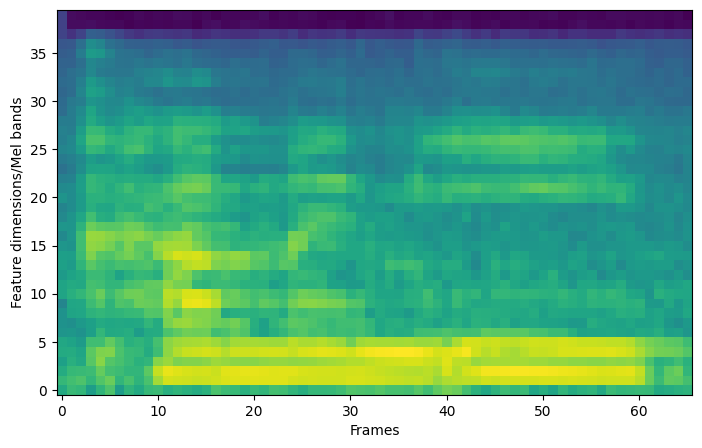

In [4]:
y_fn = "come_and_eat.wav"
remove_trailing_silence(y_fn)
f_s, search = wavfile.read(filtered)
print(f_s)
# Mel-scale spectrogram
n_fft = int(0.025*f_s)      # 25 ms
hop_length = int(0.01*f_s)  # 10 ms
mel_spec_y = librosa.feature.melspectrogram(
    search/1.0, sr=f_s, n_mels=40,
    n_fft=n_fft, hop_length=hop_length
    )
log_mel_spec_y = np.log(mel_spec_y)
y_seq = log_mel_spec_y.T

print("S before T")
print(log_mel_spec_y.shape)
print("S after T")
print(y_seq.shape)
print(y_seq.dtype)

# Plot log-Mel spectrogram
fig, ax = plt.subplots(figsize=(9, 5))
ax.imshow(log_mel_spec_y, origin="lower", interpolation="nearest");
plt.ylabel("Feature dimensions/Mel bands")
plt.xlabel("Frames");


In [5]:
s_eat = splitSearch(eat_seq, y_seq, 3)
print("len of eat searches")
print(len(s_eat))
s_fetch = splitSearch(fetch_seq, y_seq, 3)
print("len of fetch searches")
print(len(s_fetch))
s_sit = splitSearch(sit_seq, y_seq, 3)
print("len of sit searches")
print(len(s_sit))
s_name = splitSearch(name_seq, y_seq, 3)
print("len of name searches")
print(len(s_name))
s_lay = splitSearch(lay_seq, y_seq, 3)
print("len of lay searches")
print(len(s_lay))

len of eat searches
14
len of fetch searches
8
len of sit searches
15
len of name searches
13
len of lay searches
1


In [6]:
num_costs=[]
costs_eat = getCosts(eat_seq, s_eat)
print("len of eat costs")
print(len(costs_eat))
num_costs.append(len(costs_eat))
costs_fetch = getCosts(fetch_seq, s_fetch)
print("len of fetch costs")
print(len(costs_fetch))
num_costs.append(len(costs_fetch))
costs_sit = getCosts(sit_seq, s_sit)
print("len of sit costs")
print(len(costs_sit))
num_costs.append(len(costs_sit))
costs_name = getCosts(name_seq, s_name)
print("len of name costs")
print(len(costs_name))
num_costs.append(len(costs_name))
costs_lay = getCosts(lay_seq, s_lay)
print("len of lay costs")
print(len(costs_lay))
num_costs.append(len(costs_lay))
print(num_costs)

len of eat costs
14
len of fetch costs
8
len of sit costs
15
len of name costs
13
len of lay costs
1
[14, 8, 15, 13, 1]


Text(0.5, 1.0, 'Unscaled Segment Axis of "Come and eat"')

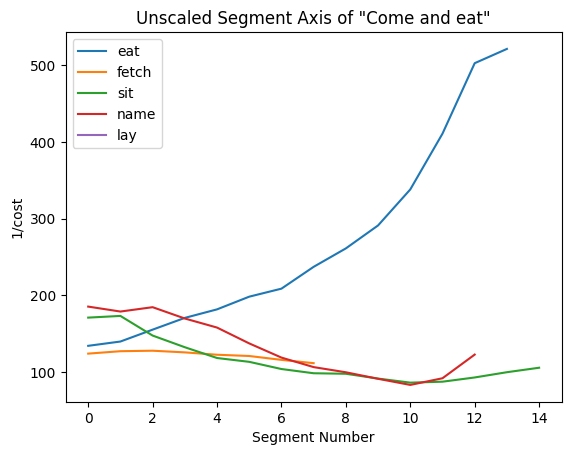

In [13]:
plot_cost=[]
for i in costs_eat:
    plot_cost.append(1/i)
plt.plot(range(0,len(costs_eat)),plot_cost, label='eat')
plot_cost=[]
for i in costs_fetch:
    plot_cost.append(1/i)
plt.plot(range(0,len(costs_fetch)),plot_cost, label='fetch')
plot_cost=[]
for i in costs_sit:
    plot_cost.append(1/i)
plt.plot(range(0,len(costs_sit)),plot_cost, label='sit')
plot_cost=[]
for i in costs_name:
    plot_cost.append(1/i)
plt.plot(range(0,len(costs_name)),plot_cost, label='name')
plot_cost=[]
for i in costs_lay:
    plot_cost.append(1/i)
plt.plot(range(0,len(costs_lay)),plot_cost, label='lay')
plt.legend()
plt.xlabel('Segment Number')
plt.ylabel('1/cost')
plt.title('Unscaled Segment Axis of "Come and eat"')

1.1538461538461537
2.142857142857143
1.0714285714285714
1.25
15


Text(0.5, 1.0, 'Scaled Segment Axis')

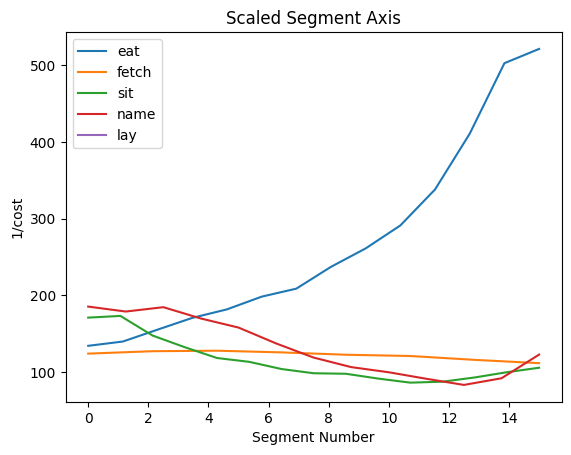

In [11]:
plot_cost=[]
for i in costs_eat:
    plot_cost.append(1/i)
x=getScaled(num_costs, 0)
plt.plot(x,plot_cost, label='eat')
plot_cost=[]
for i in costs_fetch:
    plot_cost.append(1/i)
x=getScaled(num_costs, 1)
plt.plot(x,plot_cost, label='fetch')
plot_cost=[]
for i in costs_sit:
    plot_cost.append(1/i)
x=getScaled(num_costs, 2)
plt.plot(x,plot_cost, label='sit')
plot_cost=[]
for i in costs_name:
    plot_cost.append(1/i)
x=getScaled(num_costs, 3)
plt.plot(x,plot_cost, label='name')
plot_cost=[]
for i in costs_lay:
    plot_cost.append(1/i)
x=getScaled(num_costs, 4)
plt.plot(x,plot_cost, label='lay')
plt.legend()
plt.xlabel('Segment Number')
plt.ylabel('1/cost')
plt.title('Scaled Segment Axis')